In [1]:
from visualization_tools import *
import pandas as pd
import json


In [2]:
run_number = range(1, 33)
task = "tensorflow"
folder = "C:\\Users\\lamec\\WORK\\journal\\dumps"

# Create the DataFrame with specified columns and data types
df = pd.DataFrame({
    'Experiment name': pd.Series(dtype='string'),
    'Run number': pd.Series(dtype='string'),
    'Individual number': pd.Series(dtype='int64'),
    'Phenotype': pd.Series(dtype='string'),
    'Smart Phenotype': pd.Series(dtype='string'),
    'Fitness': pd.Series(dtype='float64')
})


df = load_results(folder)



C:\Users\lamec\WORK\journal\dumps\SM\run_1\iteration_0.json 0
C:\Users\lamec\WORK\journal\dumps\SM\run_1\iteration_1.json 1
C:\Users\lamec\WORK\journal\dumps\SM\run_1\iteration_10.json 10
C:\Users\lamec\WORK\journal\dumps\SM\run_1\iteration_11.json 11
C:\Users\lamec\WORK\journal\dumps\SM\run_1\iteration_12.json 12
C:\Users\lamec\WORK\journal\dumps\SM\run_1\iteration_2.json 2
C:\Users\lamec\WORK\journal\dumps\SM\run_1\iteration_3.json 3
C:\Users\lamec\WORK\journal\dumps\SM\run_1\iteration_4.json 4
C:\Users\lamec\WORK\journal\dumps\SM\run_1\iteration_5.json 5
C:\Users\lamec\WORK\journal\dumps\SM\run_1\iteration_6.json 6
C:\Users\lamec\WORK\journal\dumps\SM\run_1\iteration_7.json 7
C:\Users\lamec\WORK\journal\dumps\SM\run_1\iteration_8.json 8
C:\Users\lamec\WORK\journal\dumps\SM\run_1\iteration_9.json 9
C:\Users\lamec\WORK\journal\dumps\SM\run_10\iteration_0.json 0
C:\Users\lamec\WORK\journal\dumps\SM\run_10\iteration_1.json 1
C:\Users\lamec\WORK\journal\dumps\SM\run_10\iteration_10.json 

In [3]:
df

,Experiment name,Run number,Individual number,Generation,Phenotype,Smart Phenotype,Fitness
0,SM,run_1,159,0,"alpha_func, beta_func, sigma_func, grad_func =...","multiply(grad, constant(6.23645483e-01))",-0.850022
1,SM,run_1,90,0,"alpha_func, beta_func, sigma_func, grad_func =...","multiply(grad, sqrt(constant(1.14904229e-03)))",-0.805911
2,SM,run_1,14,0,"alpha_func, beta_func, sigma_func, grad_func =...","add(multiply(constant(9.99847452e-01), negativ...",-0.251178
3,SM,run_1,175,0,"alpha_func, beta_func, sigma_func, grad_func =...","subtract(grad, divide_no_nan(grad, divide_no_n...",-0.170978
4,SM,run_1,119,0,"alpha_func, beta_func, sigma_func, grad_func =...","divide_no_nan(divide_no_nan(grad, grad), grad)",-0.165800
...,...,...,...,...,...,...,...
444795,SM,run_9,67,9,"alpha_func, beta_func, sigma_func, grad_func =...",beta,0.000000
444796,SM,run_9,158,9,"alpha_func, beta_func, sigma_func, grad_func =...",constant(2.83228820e-02),0.000000
444797,SM,run_9,508,9,"alpha_func, beta_func, sigma_func, grad_func =...",constant(4.18339400e-02),0.000000
444798,SM,run_9,191,9,"alpha_func, beta_func, sigma_func, grad_func =...",square(alpha),0.000000


In [20]:
 # Assuming you already have the DataFrame, let's call it 'df'

# Group by 'Experiment name' and 'Run number', then count the entries in each group
individual_counts = df.groupby(['Experiment name', 'Run number'])['Individual number'].nunique().reset_index(name='Unique Individual Count')
df['Fitness'] = df['Fitness'] * -1
print(individual_counts)

   Experiment name Run number  Unique Individual Count
0               SM      run_1                     1203
1               SM     run_10                     2947
2               SM     run_11                     3905
3               SM     run_12                     3507
4               SM     run_13                      493
5               SM     run_14                     2824
6               SM     run_15                     3382
7               SM     run_16                     3114
8               SM     run_17                     2305
9               SM     run_18                     3252
10              SM     run_19                     2725
11              SM      run_2                     5687
12              SM     run_20                     3182
13              SM     run_21                     3053
14              SM     run_22                     3154
15              SM     run_23                     2713
16              SM     run_24                     3198
17        

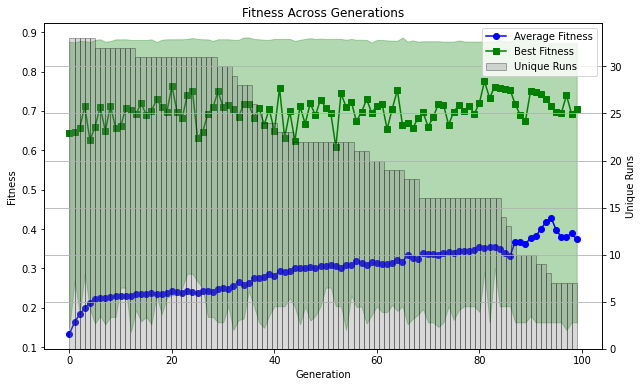

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with columns 'Generation', 'Fitness', 'Experiment name', and 'Run number'

# Step 1: Group by 'Experiment name', 'Run number', and 'Generation', and compute the mean and max fitness for each group
fitness_data = df.groupby(['Experiment name', 'Run number', 'Generation'])['Fitness'].agg(['mean', 'max']).reset_index()

# Step 2: Group by 'Generation' and compute the overall mean and max fitness for each generation
generation_stats = fitness_data.groupby('Generation').agg({'mean': 'mean', 'max': 'mean', 'Run number': 'nunique'}).reset_index()
generation_stats.rename(columns={'Run number': 'Unique Runs'}, inplace=True)

# Step 3: Calculate highest and lowest fitness across all runs per generation from the max fitness data
highest_fitness = fitness_data.groupby('Generation')['max'].max().reset_index()
lowest_fitness = fitness_data.groupby('Generation')['max'].min().reset_index()

# Step 4: Plot the average fitness, best fitness, and the shadow for the range between highest and lowest fitness
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average fitness on the first y-axis
ax1.plot(generation_stats['Generation'], generation_stats['mean'], marker='o', linestyle='-', color='b', label='Average Fitness')
ax1.plot(generation_stats['Generation'], generation_stats['max'], marker='s', linestyle='-', color='g', label='Best Fitness')
ax1.fill_between(generation_stats['Generation'], lowest_fitness['max'], highest_fitness['max'], alpha=0.3, color='g')

ax1.set_xlabel('Generation')
ax1.set_ylabel('Fitness')
ax1.set_title('Fitness Across Generations')

# Create a secondary y-axis for the histogram
ax2 = ax1.twinx()

# Plot transparent histogram for unique runs on the secondary y-axis
ax2.hist(generation_stats['Generation'], bins=len(generation_stats), alpha=0.3, color='gray', edgecolor='black',
         weights=generation_stats['Unique Runs'], label='Unique Runs')
ax2.set_ylabel('Unique Runs')

# Combine the legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

plt.grid(True)
plt.show()


In [ ]:
from smart_phenotype import smart_phenotype, readable_phenotype
import random
def genealogy_string(results):
    import graphviz
    epochs = np.arange(len(results[0]))
    lineage = []
    fitness_color = []
    occurences = {}
    rendered = set()
    prune_cutoff = 20
    string = """digraph genealogy{
fontname="Helvetica,Arial,sans-serif"
node [fontname="Helvetica,Arial,sans-serif"]
edge [fontname="Helvetica,Arial,sans-serif"]
# page = "8.2677165,11.692913" ;
ratio = "auto" ;
mincross = 2.0 ;
label = "Genealogy" ;


"""
    connections_string = ""
    for iteration in epochs:     
        for result in results:
            for indiv in result[iteration]:
                if "parent" in indiv:
                    for parent in indiv["parent"]:
                        if parent in occurences:
                            occurences[parent] += 1
                        else: 
                            occurences[parent] = 1
                        if indiv['id'] in occurences:
                            occurences[indiv['id']] += 1
                        else: 
                            occurences[indiv['id']] = 1  
                        lineage.append((parent, indiv['id'], indiv['fitness'] * -1))
                fitness_color.append((indiv['id'], indiv['fitness'] * -1))
    for parent, child, fitness in set(lineage):
        if fitness > 0.12 and occurences[parent] > prune_cutoff and occurences[child] > prune_cutoff:
            connections_string+=(f'\n "{parent}" -> "{child}" ;')    
            rendered.add(parent)
            rendered.add(child)
    for id, fitness in set(fitness_color):
        if fitness > 0.12 and id in rendered:
            string+=(f'\n "{id}" [style=filled,fillcolor="#{format(int(255-fitness*255), "x")}{format(int(255-fitness*255), "x")}ff", width={fitness*10}, height={fitness*10}] ;')

    string += connections_string + "\n }"
    with open("graph.dot", "w") as f:
        print(string,file=f)
    src = graphviz.Source(string)
    src.render('doctest-output/graph.gv', view=True).replace('\\', '/')
    return string

#print(genealogy_string(results))
def load_archive(path, run_number, generation):
    with open(path + str(run_number) + '\\z-archive_' + str(generation) + ".json", 'r') as f:
        archive = json.load(f)
    return archive

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def trim_phenotype(phenotype):
    if "shape" in phenotype:
        phenotype = phenotype.replace(", shape=shape, dtype=tf.float32", "")
        phenotype = phenotype.replace("tf.math.", "")
        phenotype = phenotype.replace("tf.", "")
        functions = phenotype.split(r'lambda shape,  alpha')

    elif "size" in phenotype:
        phenotype = phenotype.replace(", size=size, dtype=torch.float32", "")
        phenotype = phenotype.replace("torch.", "")        
        functions = phenotype.split(r'lambda size, alpha')
    
    else:
        raise Exception()

    return functions 

def math_phenotype(phenotype):
    functions = trim_phenotype(phenotype)
    alpha_func_string = functions[1][8:-2]
    beta_func_string =functions[2][14:-2] 
    sigma_func_string =functions[3][21:-2] 
    grad_func_string = functions[-1][21:]
    
    return grad_func_string

In [ ]:
class Node:
    def __init__(self, symbol, parent, child_count):
        self.symbol = symbol
        self.left = None
        self.right = None
        self.child = None
        self.parent = parent
        self.child_count = child_count
            
    def insert(self, child):
        if self.child_count == 2:
            if self.left is None:
                self.left = child
            elif self.left.is_full() == False:
                #print(f"inserting in {self.left.symbol}")
                self.left.insert(child)
            elif self.right is None:
                self.right = child
            elif self.right.is_full() == False:
                #print(f"inserting in {self.right.symbol}")
                self.right.insert(child)
            else:
                raise Exception(f"All two children are full:{self.symbol}({self.left.symbol}, {self.right.symbol}) [{self.get_root().to_string()}]")
        elif self.child_count == 1:
            if self.child is None:
                self.child = child
            elif self.child.is_full() == False:
                #print(f"inserting in {self.child.symbol}")
                self.child.insert(child)
            else:
                raise Exception(f"Child is full: {self.symbol}({self.child.symbol}) [{self.get_root().to_string()}]")
        else:
            raise Exception(f"Insert called on terminal: {self.symbol} [{self.get_root().to_string()}]")
            
    def is_full(self):
        #print(f"Calling is full on {self.symbol}")
        full = 0
        if self.child_count == 2:
            if self.left is None:
                full = False
            elif self.right is None:
                full = False
            elif self.left.is_full() and self.right.is_full():
                full = True
            else: 
                full = False
        elif self.child_count == 1:
            if self.child is None:
                full = False
            elif self.child.is_full():
                full = True
            else:
                full = False
        elif self.child_count == 0:
            full = True
        else:
            raise Exception(f"Symbol {self.symbol} does not 0, 1 or 2 children")
        return full
        
    def get_next(self):
        return self



    def to_string(self):
        string = ""
        if self.child_count == 2:
            string +="(" 
            if self.left is None:
                string += "_"
            else:
                string += self.left.to_string()
            string += self.symbol
            if self.right is None:
                string += "_"
            else:
                string += self.right.to_string()
            string += ")"
            
        elif self.child_count == 1:
            string += self.symbol + "(" 
            if self.child is None:
                string += "_"
            else:
                string += self.child.to_string()
            string += ")"
        else:
            string += self.symbol
        return string

    def get_root(self):
        if self.parent is not None:
            return self.parent.get_root()
        else:
            return self
        
        
def process_results(results, negative_fit=True, run_number=None):
    epochs = np.arange(len(results[0]))
    #print(epochs)
    best_individuals = {}
    averages_all = []
    bests_all = []
    stds_all = []
    best_of_all = []
    stds_best_all = [] 
    indivs = []
    indiv_fits = []
    indivs_epochs = []
    indivs_per_epoch = []
    boa_fit = 0
    boa_indiv = None
    run_best = np.zeros(len(results))
    for iteration in epochs:
        averages_all.append([])
        bests_all.append([])
        stds_all.append([])
        indivs_per_epoch.append([])
        best_of_all.append(0)
        stds_best_all.append(0)    
        run = 0  
        for result in results:
            all_fits = []
            best = 0
            gen_best = 0
            if iteration < len(result):
                for indiv in result[iteration]:
                    if negative_fit:
                        indiv["fitness"] *= -1
                    indiv['run'] = run
                    if 'smart_phenotype' not in indiv:
                        indiv['smart_phenotype'] = smart_phenotype(indiv["phenotype"])
                    indivs.append(indiv)
                    indiv_fits.append(indiv['fitness'])
                    indivs_epochs.append(iteration)
                    indivs_per_epoch[iteration].append(indiv['fitness'])
                    if indiv['fitness'] > run_best[run]:
                        run_best[run] = indiv['fitness']
                        if run_number is None:
                            print(f'------NEW BEST IN RUN------\n{iteration}-{indiv["id"]}-{boa_fit}\n{smart_phenotype(indiv["phenotype"])}\n--------------------')
                        else:
                            print(f'------NEW BEST IN RUN {run_number[run]}------\nEPOCH:{iteration}\nID:{indiv["id"]}-{boa_fit}\n{readable_phenotype(indiv["phenotype"])}\n{indiv["phenotype"]}--------------------')      
                    if indiv['fitness'] > best:
                        best = indiv['fitness']
                        if indiv['fitness'] > boa_fit:
                            boa_fit = best
                            best_individuals[iteration] = {"fitness": boa_fit, "phenotype": indiv["phenotype"], "smart_phenotype": smart_phenotype(indiv["phenotype"])}
                    best = best if indiv['fitness'] < best else indiv['fitness']
                    all_fits.append(indiv['fitness'])
                averages_all[iteration].append(np.average(all_fits))
                stds_all[iteration].append(np.std(all_fits))
                bests_all[iteration].append(best)
            run += 1
        stds_best_all[iteration] = np.std(bests_all[iteration]) 
        stds_all[iteration] = np.std(averages_all[iteration])
        averages_all[iteration] = np.average(averages_all[iteration])
        best_of_all[iteration] = np.max(bests_all[iteration])  
        bests_all[iteration] = np.average(bests_all[iteration])
    return {"averages_all": averages_all, "bests_all": bests_all, "indivs": indivs, "indivs_epochs": indivs_epochs, "epochs": epochs}

def plot_fit(epochs, averages_all, bests_all): 
    plt.figure(facecolor='#eff2f1')
    
    ax = plt.axes()
    ax.set_facecolor(color="#eff2f1")
    ax.spines['bottom'].set_color('#08415c')
    ax.spines['top'].set_color('#08415c')
    ax.spines['left'].set_color('#08415c')
    ax.spines['right'].set_color('#08415c')
    ax.xaxis.label.set_color('#08415c')
    ax.yaxis.label.set_color('#08415c')
    ax.tick_params(axis='x', colors='#08415c')
    ax.tick_params(axis='y', colors="#08415c")
    plt.plot(epochs, averages_all, label='population average', color="#7796cb")
    #plt.fill_between(epochs, [i + j for i, j in zip(averages_all, stds_all)], [i - j for i, j in zip(averages_all, stds_all)], alpha=0.2)
    plt.plot(epochs, bests_all, label='best average', color="#EFA00B")   
    #plt.fill_between(epochs, [i + j for i, j in zip(bests_all, stds_best_all)], [i - j for i, j in zip(bests_all, stds_best_all)], alpha=0.2)
    plt.xlabel('Generation')
    plt.ylabel('Accuracy')
    plt.savefig(f'best_average_evolution{run_number}.png')
    plt.savefig(f'best_average_evolution{run_number}.pdf')
    plt.show()

def pop_density_heatmap(epochs, indivs, rows=10, columns=10, fit_floor=0, fit_ceil=1, gen_floor=0.0, gen_ceil=100.0):
    epoch_len = gen_ceil - gen_floor
    heatmap_matrix = np.zeros((rows, columns), dtype=np.int32)
    fit_range = fit_ceil - fit_floor
    row_labels = [f"{(fit_range) / rows * x + fit_floor:.2f},{(fit_range) / rows * (x + 1) + fit_floor:.2f}" for x in range(rows)]
    columns_labels = [f"{int((epoch_len) / columns * x)},{int((epoch_len) / columns * (x + 1))}" for x in range(columns)]
    for epoch, indiv in zip(epochs, indivs):
        if indiv["fitness"] >= fit_floor and indiv["fitness"] <= fit_ceil and epoch > gen_floor and epoch < gen_ceil:
            row_index = int((indiv["fitness"] - fit_floor) / fit_range * rows)
            column_index = int(float(epoch) / float(epoch_len) * columns)
            heatmap_matrix[row_index][column_index] += 1
    fig, ax = plt.subplots()
    im, cbar = heatmap(heatmap_matrix, row_labels, col_labels=columns_labels, ax=ax, cbarlabel="indiv count", cmap="Greys")
    texts = annotate_heatmap(im,valfmt="{x:.1E}")
    fig.tight_layout()
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Individuals Density Heatmap (Generation vs Fitness)')
    plt.show()

def unique_indivs_heatmap(epochs, indivs, rows=10, columns=10, fit_floor=0, fit_ceil=1, gen_floor=0.0, gen_ceil=100.0):
    epoch_len = gen_ceil - gen_floor
    heatmap_matrix = np.zeros((rows, columns), dtype=np.int32)
    unique_indivs_record = {}
    fit_range = fit_ceil - fit_floor
    row_labels = [f"{(fit_range) / rows * x + fit_floor:.2f},{(fit_range) / rows * (x + 1) + fit_floor:.2f}" for x in range(rows)]
    columns_labels = [f"{int((epoch_len) / columns * x)},{int((epoch_len) / columns * (x + 1))}" for x in range(columns)]
    for epoch, indiv in zip(epochs, indivs):
        if indiv["fitness"] >= fit_floor and indiv["fitness"] <= fit_ceil and epoch > gen_floor and epoch < gen_ceil:
            row_index = int((indiv["fitness"] - fit_floor) / fit_range * rows)
            column_index = int(float(epoch) / float(epoch_len) * columns)
            if row_index not in unique_indivs_record:
                unique_indivs_record[row_index] = {}
            if column_index not in unique_indivs_record[row_index]:
                unique_indivs_record[row_index][column_index] = []
            if indiv["smart_phenotype"] not in unique_indivs_record[row_index][column_index]:
                if epoch == epochs[-1]:
                    print(indiv["smart_phenotype"])
                unique_indivs_record[row_index][column_index].append(indiv["smart_phenotype"])
                heatmap_matrix[row_index][column_index] += 1
    fig, ax = plt.subplots()
    im, cbar = heatmap(heatmap_matrix, row_labels, col_labels=columns_labels, ax=ax, cbarlabel="unique indiv count", cmap="Greys")
    texts = annotate_heatmap(im)
    fig.tight_layout()
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Unique Individuals Density Heatmap (Generation vs Fitness)')
    plt.show()



In [ ]:
data = process_results(results, run_number=run_number)

In [ ]:
columns, rows = (40, 10)
plt.rcParams['figure.figsize'] = [columns, rows]
plot_fit(data["epochs"], data['averages_all'], data['bests_all'])

fit_floor = 0.0
fit_ceil = 1.0
gen_floor = 0.0
gen_ceil = float(len(data['epochs']))
pop_density_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)
unique_indivs_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)


In [ ]:
archive_list = []
for i in run_number: 
    it = 1 
    try:
        while True:
            archive = load_archive(path, i, it)
            it += 1
    except:
        pass
    try:
        print(f"loading archive {it - 1} for run {i}")
        archive = load_archive(path, i, it - 1)
        for x in archive:
            if 'fitness' in archive[x]:
                archive_list.append([x, archive[x], archive[x]['fitness'], i])
    except:
        print(f"Run {i} has no archive")
archive_list.sort(key=lambda x : x[2])



In [ ]:
archive_list
with open('data.json', 'w') as f:
    json.dump(archive_list, f)

In [ ]:
it = 0
while it < 10:
    print(archive_list[it])
    it+=1

In [ ]:
def turn_to_expr(phenotype, tree):
    if phenotype == "":
        return tree
    
    if phenotype[0:9] == "multiply(":
        #print("multiply")
        phenotype = phenotype[9:]
        node = Node("*", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:14] == "divide_no_nan(":
        phenotype = phenotype[14:]
        node = Node("/", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "add(":
        phenotype = phenotype[4:]
        node = Node("+", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "pow(":
        phenotype = phenotype[4:]
        node = Node("^", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:9] == "subtract(":
        phenotype = phenotype[9:]
        node = Node("-", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "grad":
        phenotype = phenotype[4:]
        node = Node("grad", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "beta":
        phenotype = phenotype[4:]
        node = Node("beta", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:5] == "alpha":
        phenotype = phenotype[5:]
        node = Node("alpha", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:5] == "sigma":
        phenotype = phenotype[5:]
        node = Node("sigma", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:9] == "negative(":
        phenotype = phenotype[9:]
        node = Node("-", tree, 1)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:5] == "sqrt(":
        phenotype = phenotype[5:]
        node = Node("sqrt", tree, 1)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:7] == "square(":
        phenotype = phenotype[7:]
        node = Node("square", tree, 1)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:2] == ", ":
        phenotype = phenotype[2:]
        return turn_to_expr(phenotype, tree)     
    elif phenotype[0] == ")":
        phenotype = phenotype[1:]
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:9] == "constant(":
        if phenotype[9:12] == "0.0" or phenotype[9:13] == "1.0)" or phenotype[9:13] == "1.0,":
            node = Node(phenotype[9:12], tree, 0)
            phenotype = phenotype[12:]
            tree.insert(node)
            tree = tree.get_next()           
        else:
            node = Node(phenotype[9:9+14], tree, 0)
            phenotype = phenotype[9+14:]
            tree.insert(node)
            tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    else:
        raise Exception(phenotype)
        
def math_phenotype(phenotype):
    functions = trim_phenotype(phenotype)
    alpha_func_string = functions[1][8:-2]
    beta_func_string =functions[2][14:-2] 
    sigma_func_string =functions[3][21:-2] 
    grad_func_string = functions[-1][21:]
    
    for x in [alpha_func_string, beta_func_string, sigma_func_string, grad_func_string]:
        print(x)    
        turn_to_expr(x, Node("", None, 1)).to_string()

    return grad_func_string

for indiv in data['indivs']:
    math_phenotype(indiv['phenotype'])

In [ ]:
a = "multiply("
print(a[0:9])
print(a[9:])

In [ ]:
from copy import deepcopy
import csv
from pickle import NONE
from utils.data_functions import load_fashion_mnist_training, load_cifar10_training, load_mnist_training, select_fashion_mnist_training
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

from keras.models import load_model
from tensorflow import keras
from keras import backend as K
from optimizers.custom_optimizer import CustomOptimizer
import datetime
experiment_time = datetime.datetime.now()

cached_dataset = None
cached_model = None

def train_model_tensorflow_cifar10(phen_params):
    phen, params = phen_params
    validation_size = params['VALIDATION_SIZE']
    fitness_size =params['FITNESS_SIZE'] 
    batch_size = params['BATCH_SIZE']
    epochs = params['EPOCHS']
    patience = params['PATIENCE']

    # Note that globals are borderline -- consider an object or a closure 
    # deliberately using globals() to make it ugly...
    if globals()['cached_dataset'] == None:
        globals()['cached_dataset'] = load_cifar10_training(validation_size=validation_size, test_size=fitness_size)
    
    if globals()['cached_model'] == None:
        globals()['cached_model'] = load_model(params['MODEL'], compile=False)
        
    # we assume validation and test sets are deterministic
    dataset = globals()['cached_dataset'] 
    model = tf.keras.models.clone_model(globals()['cached_model'])

    weights = model.get_weights()
    model.set_weights(weights)  

    # optimizer is constant aslong as phen doesn't changed?
    # -> opportunity to cache opt and compiled model
    opt = CustomOptimizer(phen=phen, model=model)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)

    score = model.fit(dataset['x_train'], dataset['y_train'],
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(dataset['x_val'], dataset['y_val']),
        validation_steps= validation_size // batch_size,
        callbacks=[
            early_stop
        ])

    K.clear_session()
    results = {}
    for metric in score.history:
        results[metric] = []
        for n in score.history[metric]:
            results[metric].append(n)
    test_score = model.evaluate(x=dataset['x_test'],y=dataset["y_test"], verbose=0, callbacks=[keras.callbacks.History()])
    return test_score[-1], results
